In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
import numpy as np
import random
import skimage
from skimage import color, exposure
from skimage.feature import hog
import os
import glob


In [11]:
############ Loading Data ###############

from load import *

stks = np.load("data/cyril_preproc.npy")

files = []
for i in range(1,4):
    for j in range(1,5):
        prefix = '/Users/niranjaniprasad/Dropbox/Desktop/COS598C/amg/AMG%d_exp%d'%(i,j)
        files.append( (prefix+'.tif', prefix+'.zip') )

rois = []
for i,(s,r) in enumerate(files):
    if i==8: rois.append((load_rois(r, 512, 512, xdisp=9, ydisp=-1)))
    else: rois.append((load_rois(r, 512, 512)))
        
data = zip(stks, rois)

del stks, rois

#np.save

In [12]:
############ Data Processing Functions ###############

def normalizeTile(tile):
    return (tile - tile.mean()) / (tile.std()+0.001)

def getM(stk):
    M = stk.max(axis=0) - stk.std(axis=0)
    M = np.clip((M-900)/400, 0, 1)
    M**=0.5
    return M

def getHogTile(tile):
    fd = hog(tile, orientations=8, pixels_per_cell=(2, 2), cells_per_block=(1, 1), visualise=False)
    return fd

def getHogImg(tile):
    fd, img = hog(tile, orientations=8, pixels_per_cell=(2, 2), cells_per_block=(1, 1), visualise=True)
    return fd, img

############ Functions for testing ###############

def addNewRoi(i, j, dim, s, out_rois):
    patch = np.zeros((dim, dim))
    patch[i-s:i+s, j-s:j+s] = 1
    for x in range(0, 2*s):
        for y in range(0, 2*s):
            if (s-x)**2 + (s-y)**2 > s*s:
                patch[i-s+x, j-s+y] = 0
    out_rois.append(patch)


In [18]:
############ Training ###############
### Get positive samples ###

ftrain = [0, 1, 2, 3, 4, 5, 6, 7]
ftest = [8, 9, 10, 11]
r = 16

Zfd = []
for i in ftrain:
    stk, rois = data[i]
    M = stk
    for roi in rois:
        x,y = np.where(roi!=0)
        x,y = int(x.mean()), int(y.mean()) # compute centroid of roi
        if x-r>=0 and y-r>=0 and x+r<512 and y+r<512:
            fd = getHogTile(M[x-r:x+r, y-r:y+r])
            if fd.mean() > 0.005:
                Zfd.append(fd)            
Zfd = np.array(Zfd)

### Get negative samples ###

nZfd = []
for i in ftrain:
    stk, rois = data[i]
    M = stk
    R = rois.max(axis=0)
    n = 0; print(i)
    while n < 2000:
        x,y = [random.randint(0+r, 512-r),random.randint(0+r, 512-r)]
        if R[x-r:x+r,y-r:y+r].max() == 0:
            fd = getHogTile(M[x-r:x+r, y-r:y+r])
            if fd.mean() > 0.005:
                n = n+1
                nZfd.append(fd) 
nZfd = np.array(nZfd)

### Train SVM ### ~10 mins with 8 stacks

X = np.concatenate([Zfd,nZfd])
Y = np.concatenate([np.ones(len(Zfd)),np.ones(len(nZfd))*0])

svm1 = SVC(kernel="rbf", probability=True)
%time svm1.fit(X,Y) 

del nZfd, Zfd, X, Y

0
1
2
3
4
5
6
7
CPU times: user 9min, sys: 1.6 s, total: 9min 2s
Wall time: 9min 2s


In [52]:
############ Evaluating SVM1 ###############
### Run SVM prediction ### Slow

(stk, rois) = data[4]

dim = 512
skip = 1
r = 16
M = stk
YPred = []
for x in xrange(0+r, dim-r, skip):
    for y in xrange(0+r, dim-r, skip):
        fd = getHogTile(M[x-r:x+r, y-r:y+r])
        YPred.append(svm1.predict_proba(fd))


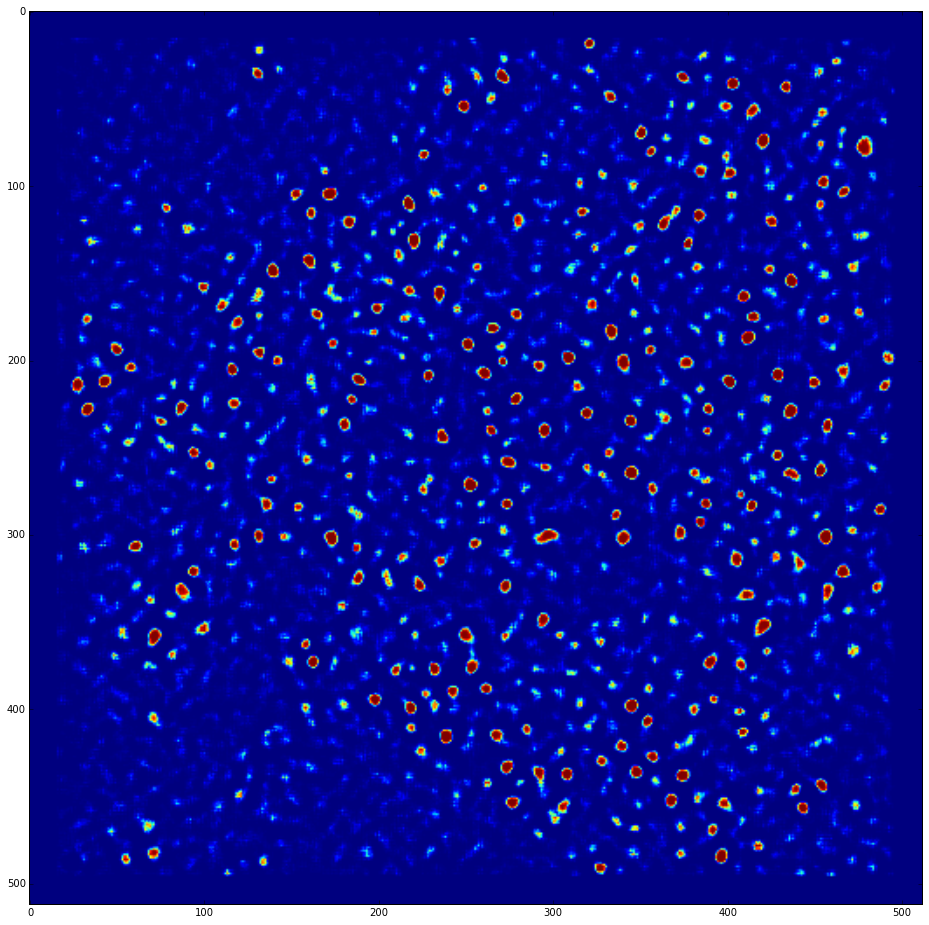

In [105]:
r = 16
c = []
for i in xrange(0+r, 512-r, skip):
    for j in xrange(0+r, 512-r, skip):
        c.append([i,j])

svmMap = np.zeros((dim, dim))
for i in range(1,len(c)):
    x,y = c[i]
    svmMap[x][y] = YPred[i][0][1]

plt.rcParams['figure.figsize'] = (16, 16)
plt.imshow(svmMap)

In [51]:
np.save("svm1", svm1)

In [122]:
s = 7
out_rois = []
roiCentres = []
for i in range(1,len(c)):
    x,y = c[i]
    if (YPred[i][0][1] > 0.8):
        #and YPred[i+1][0][1] > 0.9 and YPred[i-1][0][1] > 0.9):
        if (stk[x-s:x+s,y-s:y+s].mean() > 0.00 and y >= 16 and y <= 512-16):
            addNewRoi(x, y, dim, s, out_rois)
            roiCentres.append(c[i])
            
len(out_rois)

2255

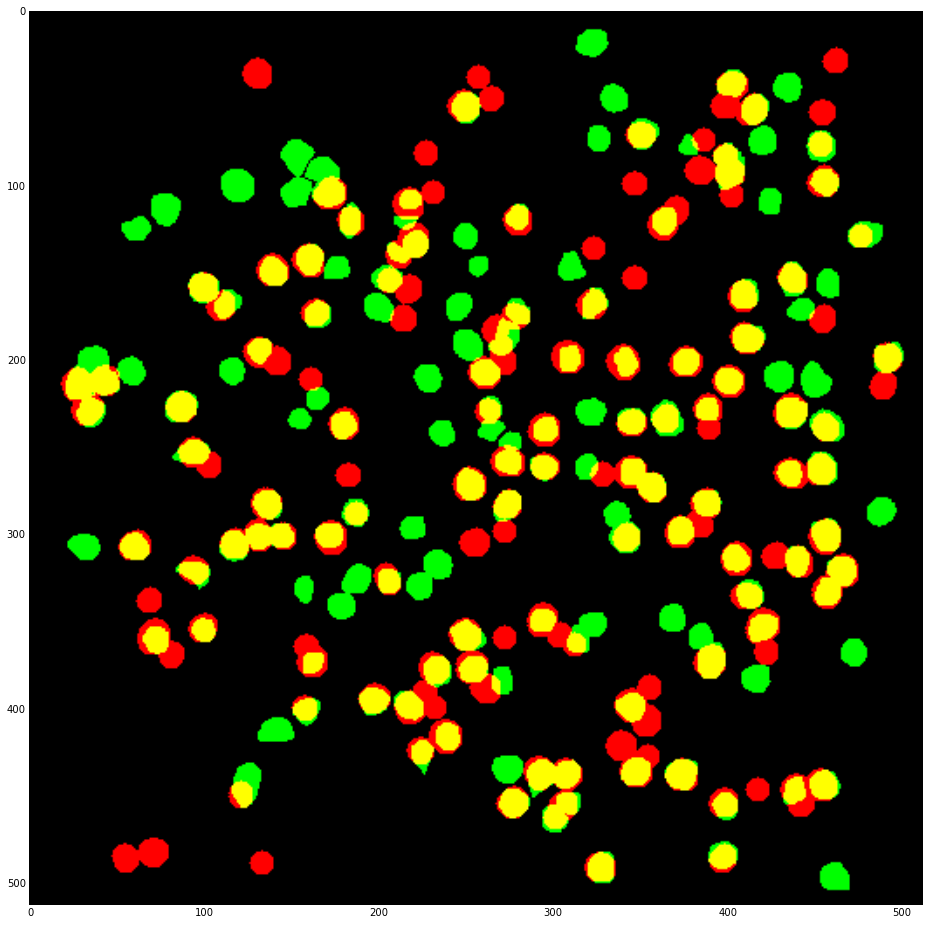

In [123]:
#r_ = np.array(out_rois)

#plt.imshow(r_.any(axis=0), cmap='gray')
K = np.zeros((dim,dim,3))
#K[:,:,0] = stk
K[:,:,0] = np.array(out_rois).any(axis=0)
K[:,:,1] = np.array(rois).any(axis=0)

plt.imshow(K)
#plt.imshow(np.array(filtered).any(axis=0), cmap='gray')
#plt.imshow(rois.any(axis=0), alpha=0.2)
#plt.imshow(stk, cmap='gray')

In [92]:
new_rois = np.array(out_rois)
r1list = []
olen = []
i = 0
while (not olen or max(olen) != 1) and i < 5:
    i = i+1
    olen = []
    print "Merge", i
    working_rois = np.array(new_rois)
    l = len(working_rois)
    new_rois = []
    done = []
    for r1 in range(l):
        if (r1 not in np.array(done)):
            r1list = [r1]
            for r2 in range(l):
                if r2 != r1:
                    s = (working_rois[r1]+working_rois[r2])
                    if (float(np.count_nonzero(s)) != 0):
                        overlap=float((np.count_nonzero(s == 2))/float(np.count_nonzero(s)))
                        if overlap > 0.4:
                            r1list.append(r2)
            #print r1, len(r1list)
            olen.append(len(r1list))
            new_rois.append((working_rois[r1list]).max(axis=0))
            done = done + r1list

filtered = []
for r in new_rois:
    if r.sum() > 100: 
        filtered.append(r)

Merge 1
Merge 2
Merge 3


In [93]:
len(filtered)

131

In [95]:
%run test.py
(stk, rois) = data[4]
score = Score(None, stk,rois,np.array(filtered))
print score

Total F1 Score      = 0.555555555556
F1 Score per stack  = [0.5555555555555556]
Total Precision     = 0.610687022901
Precision per stack = [0.6106870229007634]
Total Recall        = 0.509554140127
Recall per stack    = [0.5095541401273885]
Overlap Boundary Quality, all stacks = {'std recall': 0.094355839281068235, 'mean precision': 0.97708771332201361, 'std precision': 0.051504566497881488, 'mean recall': 0.64231261879569368}
Overlap Boundary Quality, per stack  = [{'std recall': 0.094355839281068235, 'mean precision': 0.97708771332201361, 'std precision': 0.051504566497881488, 'mean recall': 0.64231261879569368}]




In [84]:
%run test.py
score = Score(None, stk,rois,np.array(filtered))
print score

Total F1 Score      = 0.722408026756
F1 Score per stack  = [0.7224080267558527]
Total Precision     = 0.760563380282
Precision per stack = [0.7605633802816901]
Total Recall        = 0.687898089172
Recall per stack    = [0.6878980891719745]
Overlap Boundary Quality, all stacks = {'std recall': 0.1406970345855077, 'mean precision': 0.91816575998377636, 'std precision': 0.10622388006519909, 'mean recall': 0.74634197516486178}
Overlap Boundary Quality, per stack  = [{'std recall': 0.1406970345855077, 'mean precision': 0.91816575998377636, 'std precision': 0.10622388006519909, 'mean recall': 0.74634197516486178}]




In [ ]:
K = np.zeros((dim,dim,3))
K[:,:,0] = K[:,:,1] = K[:,:,2] = getM(stk)
#plt.imshow(sum(out_rois)>3)
K[:,:,2] = np.maximum(sum(out_rois), getM(stk))
#plt.imshow(np.array(out_rois).max(axis=0))
plt.imshow(K)
plt.imshow(np.array(filtered).max(axis = 0) + 2*rois.max(axis=0))

In [96]:
whos

Variable                   Type              Data/Info
------------------------------------------------------
Image                      module            <module 'PIL.Image' from <...>-packages/PIL/Image.pyc'>
ImageDraw                  module            <module 'PIL.ImageDraw' f<...>kages/PIL/ImageDraw.pyc'>
LinearSVC                  type              <class 'sklearn.svm.classes.LinearSVC'>
SVC                        ABCMeta           <class 'sklearn.svm.classes.SVC'>
Score                      classobj          __main__.Score
TestSet                    classobj          __main__.TestSet
YPred                      list              n=230400
addNewRoi                  function          <function addNewRoi at 0x109f538c0>
calc_f1_score              function          <function calc_f1_score at 0x246b9cb18>
calc_overlap               function          <function calc_overlap at 0x246bb7c80>
calc_precision_recall      function          <function calc_precision_recall at 0x137f43410>
categ

NameError: name 'c' is not defined

In [126]:
svmmap = np.load('svmmap.npy')

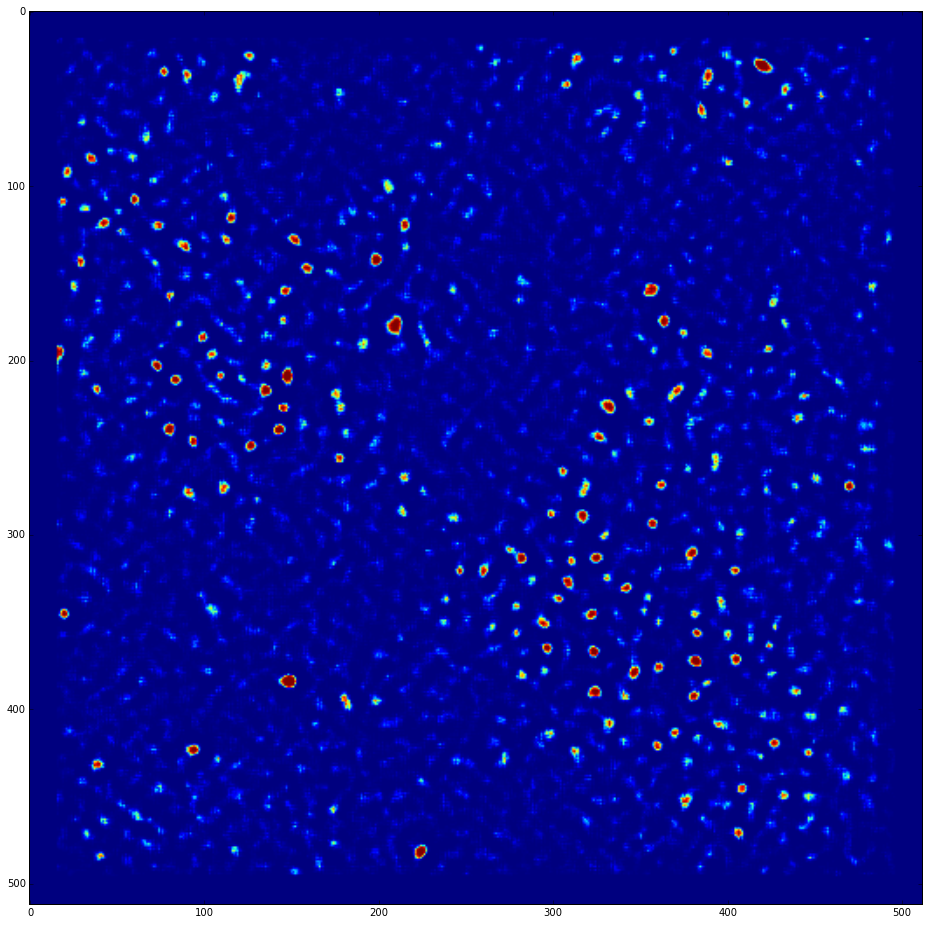

In [127]:
plt.imshow(svmmap)

In [5]:
svmOrig = np.load('svm-orig.npy')

print svmOrig[1]

In [10]:
from sklearn.externals import joblib
clf = joblib.load('svmOrig.pkl') 

In [11]:
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)